# IR Monitor

This notebook reads serial data from the ESP32 through pyserial, processes the temperature values and produces a temperaure heatmap. 

In [1]:
import numpy as np
import time
import cv2
import serial
import matplotlib.pyplot as plt
import os
from fastai.vision.all import load_learner

# %matplotlib notebook
# from matplotlib.animation import FuncAnimation
# from random import randrange
from threading import Thread

from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def td_to_img(f,tmax,tmin):
    norm = np.uint8((f - tmin)*255/(tmax-tmin))
    return norm

def is_person(x):
    if x.name.split('_')[1] == 'nusiance':
        return 'Nusiance'
    else:
        return 'Person' 

In [2]:
def simple_bounding_box_contours(img,grayscale_img, THRESH_VALUE=120, MAX_THRESH_VALUE=200, MIN_CNTR_HUMN_AREA=8,MAX_CNTR_HUMN_AREA=350):
    # THRESH_VALUE: Threshold value of the binary thresholding stage
    # MAX_THRESH_VALUE: The max threshold value each pixel below THRESH_VALUE is set to
    # MIN_CNTR_HUMN_AREA and MAX_CNTR_HUMN_AREA: Min and max values for contour areas of human body
    # Binary thresholding stage
    ret, thresh = cv2.threshold(grayscale_img, THRESH_VALUE, MAX_THRESH_VALUE, cv2.THRESH_BINARY)
    # Contour detection stage
    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # Calculate all the areas  of the detected contours
    areas = [cv2.contourArea(c) for c in contours]
    for idx, val in enumerate(areas):
        # Human blob filtration stage
        if MIN_CNTR_HUMN_AREA <= val <= MAX_CNTR_HUMN_AREA:
            cntr = contours[idx]
            # Fitting bounding boxes over our contours of interest (humans)
            x,y,w,h = cv2.boundingRect(cntr)
            # Final bounding box coordinates
            xmin = x
            ymin = y
            xmax = x+w
            ymax = y+h
            # Human bounding box instances detction stage
            cv2.rectangle(grayscale_img,(xmin,ymin),(xmax,ymax),(0,0,255),1)
            cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(0,0,255),1)
    return img

def mask(img):
    fgbg = cv2.createBackgroundSubtractorMOG2() 
    img = fgbg.apply(img)
    return img

from gluoncv import model_zoo
import mxnet as mx

def zoo(img):
    net = model_zoo.get_model('faster_rcnn_resnet50_v1b_coco', pretrained=True)
    mx_ex_int_array = mx.nd.array(img)
    box_ids, scores, bboxes = net(img)
    ax = utils.viz.plot_bbox(orig_img, bboxes[0], scores[0], box_ids[0], class_names=net.classes)
    plt.show()


c:\Users\cawin\anaconda3\lib\site-packages\gluoncv\__init__.py:40: UserWarning: Both `mxnet==1.7.0` and `torch==1.11.0+cpu` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


# Heatmap Model

KeyboardInterrupt: 

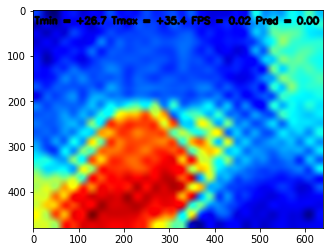

In [3]:
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath
fig = plt.figure()
ax = fig.add_subplot(111)
ser = serial.Serial('COM4', 115200)
t0 = time.time()
mlx_shape = (24,32)
load_inf = load_learner('models/resnet34_person_classifier_2022.1.pkl')
while True:
    sample = ser.readline()
    try: 
        sample = sample.decode('utf-8') # decode from byte to string
        sample = sample.split(',')
        sample = np.array(sample).astype(np.float)
        tmax = sample.max()
        tmin = sample.min()
        np.nan_to_num(0)
        sample = np.reshape(sample,mlx_shape)
        if (tmax - tmin <= 3):
            np.full((24, 32), 0)
        tg_img = td_to_img(sample,tmin,tmax)
        # Image processing
        img = cv2.applyColorMap(tg_img, cv2.COLORMAP_JET)
#             img = mask(img)
        img = simple_bounding_box_contours(img,tg_img)
        img = cv2.resize(img, (640,480), interpolation = cv2.INTER_CUBIC)
        ax.clear()
        with load_inf.no_bar():
            pred_class , _ , prediction = load_inf.predict(img)
        text = 'Tmin = {:+.1f} Tmax = {:+.1f} FPS = {:.2f} Pred = {:.2f}'.format(tmin, tmax, 1/(time.time() - t0), float(prediction[1]))
        cv2.putText(img, text, (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 3)
        ax.imshow(img)
        display(fig)
        clear_output(wait=True)
    except:
        continue

## Image Saver

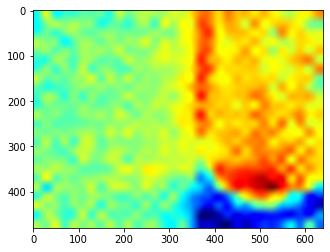

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ser = serial.Serial('COM4', 115200)
t0 = time.time()
mlx_shape = (24,32)
path = os.getcwd()

TEST_SUBJECT = "ambient"
TEST_TYPE = "nusiance"
assert("_" not in TEST_SUBJECT)
assert("_" not in TEST_TYPE)
thermal_path = os.path.join(path , 'img/thermal2/')
grayscale_path = os.path.join(path , 'img/grayscale2/')
if not os.path.exists(thermal_path):
    os.makedirs(thermal_path)
if not os.path.exists(grayscale_path):
    os.makedirs(grayscale_path)

counter = 0 

while True:
        sample = ser.readline()
        try: 
            sample = sample.decode('utf-8') # decode from byte to string
            sample = sample.split(',')
            sample = np.array(sample).astype(np.float)
            tmax = sample.max()
            tmin = sample.min()
            np.nan_to_num(0)
            sample = np.reshape(sample,mlx_shape)
            tg_img = td_to_img(sample,tmax,tmin)
            
            # Image processing
            img = cv2.applyColorMap(tg_img, cv2.COLORMAP_JET)
#             img = mask(img)
#             img,grayscale_img = simple_bounding_box_contours(img,tg_img)
            img = cv2.resize(img, (640,480), interpolation = cv2.INTER_CUBIC)
            tg_img = cv2.resize(tg_img, (640,480), interpolation = cv2.INTER_CUBIC)

            ax.clear()
#             text = 'Tmin = {:+.1f} Tmax = {:+.1f} FPS = {:.2f} Counter = {}'.format(tmin, tmax, 1/(time.time() - t0), counter)
#             cv2.putText(img, text, (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
            ax.imshow(img)
            counter += 1
            if counter > 20:
                cv2.imwrite(os.path.join(thermal_path , '{}_{}_image_{}.png'.format(TEST_SUBJECT, TEST_TYPE, counter)), img)
                cv2.imwrite(os.path.join(grayscale_path , '{}_{}_image_{}.png'.format(TEST_SUBJECT, TEST_TYPE, counter)), tg_img)
            display(fig)
            clear_output(wait=True)
        except:
            continue

# Single Image Inference

In [20]:
import pathlib
import glob
from fastai.vision.all import PILImage
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath
load_inf = load_learner('models/resnet34_person_classifier_v2.pkl')

path = os.getcwd()
img = PILImage.create(os.path.join(path, 'img\\thermal2\\cindyfeet_human_image_99.png'))
with load_inf.no_bar():
    pred_class , _ , prediction = load_inf.predict(img)
print(prediction)

TensorBase([0.0135, 0.9865])


In [ ]:
os.path.join(path, 'img\\thermal2\\cindyfeet_human_image_99.png')


In [2]:
from matplotlib import pyplot as plt
import gluoncv
from gluoncv import model_zoo
from gluoncv import data, utils
import glob
import numpy as np
import time
import mxnet as mx
import os

# set context
ctx = mx.cpu(0)

net = model_zoo.get_model('faster_rcnn_resnet50_v1b_voc', pretrained=True, ctx=ctx)
# Compile the model for faster speed
net.hybridize()
path = os.getcwd()
path = glob.glob(os.path.join(path, 'img\\testing\\*.png'))

x, orig_img = data.transforms.presets.rcnn.load_test(path,short=600)
start = time.time()
box_ids, scores, bboxes = net(np.array(x))
print("prediction time:,",(time.time()-start))
ax = utils.viz.plot_bbox(orig_img, bboxes[0], scores[0], box_ids[0], class_names=net.classes)

plt.show()

ImportError: cannot import name 'mx_int64'

In [5]:
path = os.getcwd()

from PIL import Image 
import PIL 
from pathlib import Path

net = model_zoo.get_model('faster_rcnn_resnet50_v1b_voc', pretrained=True)

# creating a image object (main image) 

im1 = Image.open()
  
# # save a image using extension
# im1.show(im1)
# plt.imshow(im1)

NameError: name 'os' is not defined

In [6]:
# Sample code

# Simple temp image
a = "27.66,27.72,26.99,27.47,28.02,28.71,27.82,28.26,28.37,28.42,28.48,29.03,29.04,28.84,28.83,29.47,28.79,28.96,28.79,28.93,28.88,28.85,28.81,28.93,27.99,28.07,28.17,28.51,28.07,28.67,27.46,28.34,27.39,27.75,27.45,27.33,27.61,27.80,28.54,28.83,28.24,28.41,28.58,28.49,29.02,29.00,28.91,29.15,29.05,29.23,28.58,28.79,28.65,28.94,28.45,28.68,28.66,28.42,28.40,28.05,28.73,28.22,28.41,28.31,27.87,27.50,27.21,27.56,27.78,28.09,27.83,28.42,28.92,29.13,28.59,28.77,28.88,29.15,29.14,29.25,29.42,29.19,29.04,28.70,29.56,29.17,28.93,28.83,28.57,28.38,28.16,28.43,28.84,28.57,27.97,28.11,27.57,27.79,27.22,27.12,27.53,27.49,28.48,28.08,28.50,28.62,28.36,28.55,29.29,29.14,29.54,29.23,29.39,29.07,29.35,28.95,29.16,29.15,28.91,29.00,28.85,28.66,28.87,28.74,28.79,28.66,28.56,28.37,27.89,27.86,27.43,27.55,27.37,27.55,27.68,28.21,28.48,28.46,28.18,28.08,28.86,29.28,29.27,29.47,29.38,29.17,29.43,29.27,29.21,29.38,29.01,29.45,29.17,29.14,28.75,29.30,29.02,29.23,28.91,28.41,28.27,27.70,27.53,27.17,27.36,27.44,27.78,28.68,28.57,28.56,27.75,28.15,28.92,29.25,29.48,29.35,29.27,29.15,29.48,29.48,29.18,29.27,29.07,29.31,28.82,28.92,28.94,29.02,28.73,29.05,28.55,28.37,27.60,28.20,27.22,27.37,27.41,27.43,28.44,28.66,28.40,28.02,27.70,28.00,28.93,29.39,31.58,31.97,31.14,30.85,29.92,29.47,29.27,29.33,28.90,29.02,28.90,28.87,28.68,28.94,28.78,29.12,28.55,28.59,27.84,27.89,27.47,26.66,27.09,27.51,28.23,28.26,28.19,27.92,27.95,28.14,28.60,28.92,31.24,32.12,31.09,30.36,29.90,29.28,28.84,29.23,28.96,28.72,28.58,28.75,28.84,28.70,29.16,28.59,28.51,28.48,28.61,28.34,26.99,27.24,27.22,27.55,28.00,28.31,28.03,27.74,27.33,27.62,28.58,28.85,30.11,31.35,30.78,30.71,31.36,30.19,28.88,28.60,28.65,28.85,28.38,28.72,28.47,28.47,28.67,28.65,28.65,28.67,28.57,28.40,27.30,26.96,27.51,27.52,28.17,28.10,27.75,27.65,27.31,27.44,28.32,29.56,31.93,32.16,32.06,32.21,31.81,30.29,29.00,28.89,28.62,28.81,28.60,28.68,28.73,28.31,28.38,28.57,28.60,28.44,28.53,28.34,27.74,27.41,27.28,27.78,27.93,28.04,27.73,27.53,27.46,27.85,28.67,29.50,33.07,32.88,32.78,33.07,31.49,29.92,28.43,28.76,28.31,28.39,28.80,28.39,28.84,28.63,28.93,28.70,28.49,28.50,28.63,28.42,28.03,27.94,27.35,27.64,28.16,27.99,27.60,27.50,27.50,27.51,27.98,28.96,33.24,33.24,33.40,33.23,30.66,29.14,28.24,28.58,28.59,28.68,28.31,28.51,28.40,28.38,28.66,28.97,28.40,28.54,29.10,29.61,28.32,27.82,27.38,28.36,27.62,27.80,27.50,27.42,27.43,27.75,26.98,27.21,31.84,33.37,33.32,33.31,28.40,27.59,27.89,28.08,28.61,28.58,28.53,28.74,28.62,28.13,28.62,28.90,28.51,29.00,29.43,28.96,28.71,27.97,27.53,27.71,27.67,27.66,27.29,27.13,27.53,27.15,27.44,27.16,31.66,33.41,33.42,33.29,28.50,27.09,27.67,27.89,28.81,28.61,28.40,28.94,28.54,28.54,28.62,29.04,29.03,29.05,29.86,29.72,28.71,27.77,27.80,28.08,27.81,27.80,27.45,27.02,27.46,27.97,28.15,28.35,31.92,33.50,33.57,33.55,30.93,29.94,29.49,29.50,29.65,29.42,28.68,28.84,29.11,29.07,29.13,29.12,28.96,29.02,30.18,29.79,28.66,27.79,27.52,27.73,27.76,27.73,27.55,27.28,28.74,29.29,30.09,30.39,32.80,33.48,33.69,33.87,31.63,30.75,31.34,30.90,30.81,30.65,29.23,29.48,28.62,29.38,28.73,28.69,29.23,29.02,29.58,29.69,28.79,28.59,28.12,27.98,27.61,28.03,28.41,28.87,30.88,31.25,31.01,31.22,31.23,31.47,31.23,31.08,30.64,30.63,30.86,31.11,31.53,31.05,31.13,30.60,30.07,29.86,29.65,29.31,29.68,30.14,29.89,29.30,29.54,28.64,27.81,27.32,27.34,27.55,28.69,29.58,30.91,31.14,31.27,31.05,30.77,31.05,30.54,30.76,30.90,30.90,30.59,30.74,31.15,31.01,31.51,31.55,31.49,31.01,30.79,30.69,31.16,30.95,29.98,29.79,29.79,29.66,27.71,27.73,27.65,28.16,29.82,30.52,30.37,30.77,30.88,30.94,31.19,31.26,30.95,31.11,31.12,31.29,30.37,30.37,29.23,29.42,30.68,31.35,32.00,32.06,32.15,31.82,31.67,31.47,29.90,30.14,29.89,29.00,27.41,27.54,27.76,28.57,30.85,31.44,30.33,30.48,30.91,30.92,31.47,31.15,30.45,30.37,30.76,30.74,30.33,30.23,28.69,28.62,28.97,29.57,30.81,31.37,32.32,31.52,31.17,31.65,30.65,30.02,29.49,29.60,28.25,27.81,29.53,30.66,31.65,31.71,29.62,29.32,30.56,30.71,30.72,30.53,30.06,29.88,29.86,30.09,30.34,29.35,27.41,27.26,28.36,28.48,28.86,29.48,31.00,30.89,31.00,31.05,30.61,30.14,29.83,29.94,28.88,29.00,30.32,31.58,31.73,31.12,29.27,29.00,30.33,30.16,30.77,30.49,30.08,30.16,30.24,30.21,29.64,29.28,27.08,27.35,27.95,28.38,27.94,27.96,27.76,28.32,28.81,29.44,30.51,29.94,29.64,29.61,29.18,30.38,31.14,31.55,30.81,29.67,27.89,28.42,29.48,29.55,30.15,29.96,30.32,30.52,30.05,30.01,29.13,28.31,26.90,27.43,28.12,28.27,27.22,27.04,27.33,26.48,27.25,26.95,29.97,29.48,29.77,29.50,29.18,29.65,30.81,30.99,29.96,28.18,27.64,27.69,29.24,29.44,29.93,30.02,30.22,30.41,30.51,30.09,29.15,28.26,27.24,27.68,28.14,28.31,27.54,26.67,27.20,26.70,27.52,26.81"
mlx_shape = (24,32) # Fixed size of mlx90640
t0 = time.time()
sample = a.split(',') # get a list of temperature values
sample = np.array(sample).astype(np.float) # Convert to np array
tmax = sample.max() # Find the min and max values of image
tmin = sample.min()
np.nan_to_num(0) # remove nan values
sample = np.reshape(sample,mlx_shape) # convert flat array to mlx_array for CV2 to process 
grayscale_img = td_to_img(sample,tmin,tmax) # Converts float dtype of temperature values to a int8, normalisation function. 
# Image processing
img = cv2.applyColorMap(grayscale_img, cv2.COLORMAP_JET)
# grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# img = mask(img)
zoo(img)
# img, grayscale_img = simple_bounding_box_contours(img,grayscale_img)
# img = cv2.resize(img, (640,480), interpolation = cv2.INTER_CUBIC)
# text = 'Tmin = {:+.1f} Tmax = {:+.1f} FPS = {:.2f}'.format(tmin, tmax, 1/(time.time() - t0))
# cv2.putText(img, text, (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
# plt.imshow(img)
# plt.show()

ValueError: In HybridBlock, there must be one NDArray or one Symbol in the input. Please check the type of the args.


In [5]:
import os
import sys
from PIL import Image
from mrcnn import visualize
from mrcnn import utils
import mrcnn.model as modellib
# If Error no keras.engine, go to mrcnn\models.py and change all references from KE to KL
from mrcnn.config import Config

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

class InferenceConfig(Config):
        # Set batch size to 1 since we'll be running inference on
        # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
        # Give the configuration a recognizable name
        NAME = "coco"
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1
        NUM_CLASSES = 1 + 80 

def load_model(model='mrcnn'):
    if model=='efficient-dt':
        return
    else:
        # Root directory of the project
        ROOT_DIR = os.path.abspath("./")

        # Import Mask RCNN
        sys.path.append(ROOT_DIR)  # To find local version of the library

        # Import COCO config
        sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version

        # Directory to save logs and trained model|
        MODEL_DIR = os.path.join(ROOT_DIR, "logs")

        # Local path to trained weights file
        COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
        # Download COCO trained weights from Releases if needed
        if not os.path.exists(COCO_MODEL_PATH):
            utils.download_trained_weights(COCO_MODEL_PATH)

        config = InferenceConfig()
        config.display()

        # Create model object in inference mode.
        model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

        # Load weights trained on MS-COCO
        model.load_weights(COCO_MODEL_PATH, by_name=True)
    return model

def predict(image: Image.Image):
    """Takes in an image and outputs, the roi(region of interest), class id and scores (percentage of certainty)
    """
    global model
    if model is None:
        model = load_model()
    results = model.detect([image], verbose=1)
    r = results[0]
    # Visualize results
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'])
    return r['rois'], r['masks'], r['class_ids'], r['scores']


c:\Users\cawin\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\cawin\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\cawin\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\cawin\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\f


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

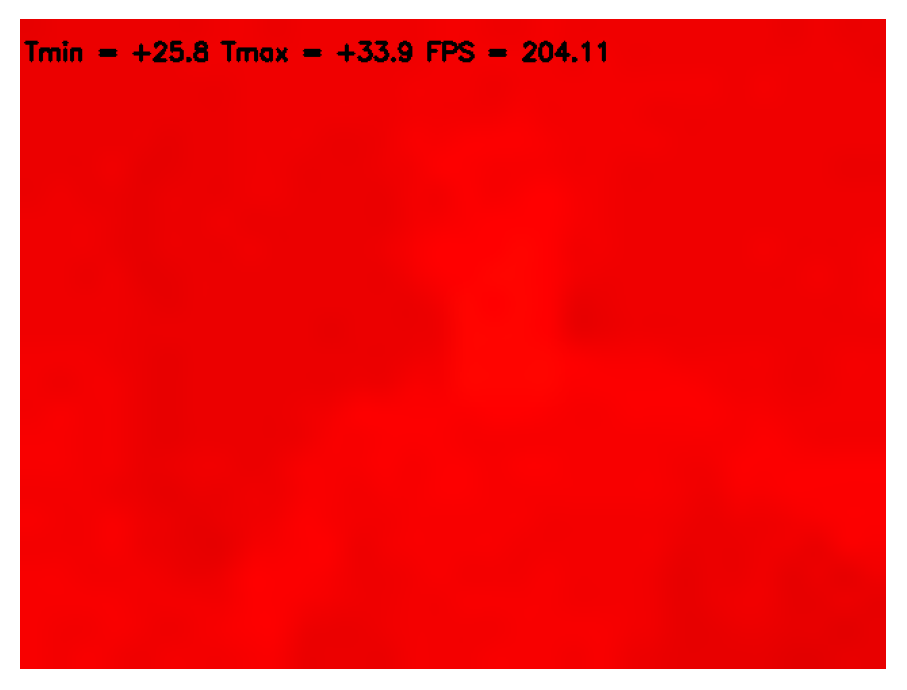

(array([], shape=(0, 4), dtype=int32),
 array([], shape=(480, 640, 0), dtype=float64),
 array([], dtype=int32),
 array([], dtype=float32))

In [31]:
# Sample code

# Simple temp image
a = "26.75,27.27,27.51,27.97,27.37,27.55,27.95,28.13,28.01,27.95,28.34,28.14,28.50,28.78,28.78,29.12,29.13,28.91,28.95,29.18,28.63,28.91,28.90,28.79,28.69,28.90,28.59,28.12,27.97,28.11,27.69,27.53,27.52,27.68,27.79,27.52,27.49,27.55,28.29,28.11,28.31,28.48,28.01,28.44,28.48,28.75,28.76,29.28,29.26,29.27,29.11,29.04,28.80,29.00,28.85,28.86,28.87,28.76,28.27,28.34,28.34,28.41,28.55,27.58,27.47,27.55,27.52,27.71,27.53,27.60,27.47,27.73,28.47,28.28,28.44,28.61,28.54,28.54,29.33,29.35,29.08,28.59,29.15,29.80,29.58,29.29,29.18,29.59,29.18,29.10,28.74,29.03,28.73,28.45,28.04,28.55,27.31,27.54,27.91,27.40,27.16,27.24,27.58,27.72,28.15,28.37,28.21,28.39,28.51,28.45,29.20,29.32,29.05,29.16,30.06,29.75,29.62,29.45,29.44,28.85,28.70,28.73,28.97,28.85,28.53,28.55,28.46,28.60,27.79,27.88,27.56,27.55,27.12,26.96,27.33,27.75,28.32,28.48,28.20,27.82,27.95,28.04,30.17,30.99,31.60,31.30,31.16,30.59,29.39,29.22,29.03,29.19,28.92,28.89,28.72,28.71,28.29,28.73,28.52,28.45,27.29,27.73,27.53,28.02,26.88,26.86,27.32,27.33,28.40,28.21,27.85,27.73,27.68,28.11,29.48,31.01,31.38,30.70,30.93,30.93,29.60,29.28,28.82,28.70,28.66,28.67,28.58,28.45,28.24,28.44,27.87,27.98,27.89,28.47,27.94,27.93,26.85,27.07,27.52,27.84,28.23,28.11,27.87,27.41,27.60,27.75,29.07,29.84,31.26,30.82,31.87,32.42,30.44,29.72,28.56,28.94,28.46,28.61,28.54,28.90,28.30,28.05,28.43,28.61,28.12,28.03,28.16,27.90,26.72,27.06,27.22,28.19,27.94,27.93,27.70,27.41,27.58,27.83,29.95,30.99,31.64,32.23,32.40,32.49,30.23,29.61,28.79,28.90,28.60,28.59,28.59,28.35,28.45,28.34,28.26,28.37,28.23,28.33,28.45,27.88,26.87,27.10,27.66,27.96,28.11,27.82,27.71,27.68,27.36,28.14,30.59,32.04,32.01,32.36,33.19,32.86,29.77,29.05,28.90,28.68,28.57,28.19,28.82,29.02,28.09,28.39,28.53,29.21,28.19,28.77,27.72,28.28,26.85,26.88,27.73,27.93,27.91,27.89,27.45,27.34,27.48,27.82,29.53,31.77,32.63,33.13,33.04,32.51,29.20,28.87,28.36,28.48,28.61,28.61,28.67,28.46,28.45,29.10,28.72,29.10,28.54,28.83,28.27,28.48,27.63,26.94,27.95,27.87,27.72,27.75,27.52,27.21,27.24,27.44,27.68,29.18,33.08,32.89,33.51,32.60,27.43,27.37,28.06,28.55,28.55,28.65,28.69,28.48,28.37,28.88,28.99,29.13,28.63,28.29,28.66,28.56,27.10,27.19,27.73,27.83,27.67,27.81,27.32,26.95,27.28,27.41,27.22,28.29,33.15,33.26,33.60,32.77,27.54,27.49,28.34,28.43,28.74,28.52,28.72,28.62,28.62,28.72,28.52,28.29,29.48,29.24,29.07,28.65,27.62,26.94,27.90,27.89,27.41,27.33,27.18,27.11,27.39,27.61,28.13,29.10,33.35,33.67,33.85,33.86,31.06,30.01,30.44,30.38,29.83,29.73,29.06,29.06,28.58,28.32,29.24,29.01,29.05,28.83,29.23,29.02,27.57,26.97,27.68,27.84,27.69,27.53,27.35,27.36,28.21,28.43,30.36,30.99,33.37,33.58,33.75,33.48,31.29,31.08,31.34,31.05,31.05,30.72,29.26,29.28,28.69,28.57,29.02,29.05,29.74,30.07,29.71,29.39,27.55,26.95,27.84,27.89,27.94,27.66,28.23,29.47,31.05,31.18,31.54,31.59,31.73,32.00,32.08,31.40,30.76,30.62,31.09,31.36,31.29,31.23,30.52,30.23,29.74,29.31,29.84,29.27,30.18,30.28,29.54,29.09,27.47,26.99,27.87,27.39,27.71,27.43,28.80,30.11,30.72,31.36,31.29,31.07,30.92,30.51,30.57,30.36,30.11,30.42,30.80,30.73,30.72,30.91,30.63,31.24,30.73,29.55,29.23,29.67,30.51,30.44,29.01,29.36,27.97,27.12,28.21,28.05,27.82,28.12,30.39,30.76,30.77,31.12,30.55,31.51,31.12,30.83,31.00,31.22,30.62,30.15,30.70,30.47,29.64,29.89,31.11,31.52,31.91,31.63,31.61,31.58,29.77,29.81,29.76,28.97,27.87,26.87,27.28,27.77,28.09,28.50,30.50,30.57,29.96,30.73,30.96,31.10,31.16,30.80,30.80,30.73,30.34,30.57,30.14,30.00,29.10,28.88,30.05,30.97,31.42,31.46,31.94,31.88,30.15,29.92,29.79,30.00,28.11,27.16,26.90,27.12,28.51,29.83,31.30,30.43,29.68,29.84,30.80,30.85,30.78,30.48,30.08,29.98,29.96,29.78,29.89,29.71,28.15,27.55,28.31,28.57,29.57,30.51,31.83,31.63,29.51,29.63,29.76,30.09,28.35,27.83,26.69,26.92,29.43,30.75,31.35,31.17,28.95,29.33,30.52,30.58,30.35,30.28,29.94,29.75,29.83,29.89,29.55,29.39,27.34,27.16,27.99,28.26,28.00,27.88,30.78,30.99,30.56,30.33,29.64,29.98,29.28,28.35,27.25,28.75,31.31,31.64,31.37,30.43,28.17,28.35,29.89,30.45,29.89,29.88,29.79,30.10,29.73,29.82,29.49,28.29,26.99,27.59,27.93,28.40,26.62,27.13,26.75,28.11,30.21,30.32,30.49,30.21,29.10,29.32,29.11,29.76,31.48,31.73,30.60,29.13,28.06,28.27,29.66,29.98,30.08,30.00,30.43,30.59,29.76,29.95,29.22,28.30,26.86,27.91,28.04,28.07,26.85,26.59,27.03,26.70,30.43,29.84,29.97,30.20,29.18,28.67,29.75,30.74,31.49,31.24,28.66,27.77,27.61,28.15,29.53,29.99,29.98,29.98,30.18,30.53,30.75,30.23,29.09,28.27,26.97,26.96,27.74,27.57,26.24,26.51,25.83,26.51,30.24,29.88,30.10,29.68,28.92,29.15,29.62,29.95,30.97,30.65,27.49,27.24,27.32,27.83,29.58,29.87,29.77,30.17,30.16,30.14,29.91,30.04,28.40,27.66,26.62,26.15,26.11,26.69,25.94,25.86,26.55,26.77"
mlx_shape = (24,32) # Fixed size of mlx90640
t0 = time.time()
sample = a.split(',') # get a list of temperature values
sample = np.array(sample).astype(np.float) # Convert to np array
tmax = sample.max() # Find the min and max values of image
tmin = sample.min()
np.nan_to_num(0) # remove nan values
sample = np.reshape(sample,mlx_shape) # convert flat array to mlx_array for CV2 to process 
tg_img = td_to_img(sample,tmin,tmax) # Converts float dtype of temperature values to a int8, normalisation function. I
# Image processing
img = cv2.applyColorMap(tg_img, cv2.COLORMAP_JET)
img = cv2.resize(img, (640,480), interpolation = cv2.INTER_CUBIC)
#             print(img.shape)
text = 'Tmin = {:+.1f} Tmax = {:+.1f} FPS = {:.2f}'.format(tmin, tmax, 1/(time.time() - t0))
cv2.putText(img, text, (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
model = load_model()
predict(img)